# Initial analysis (Louis)

In [1]:
# Add local python scripts to path
import sys
sys.path.append('../src')
import load
import clean
import aggregate
import plot

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns

## 1. Load the data in dataframes

In [3]:
characters_raw = load.character_metadata()
movies_raw = load.movie_metadata()

In [4]:
ncountries_raw = aggregate.ncountries(movies_raw)
nmovies_raw = aggregate.nmovies(movies_raw)
ncharacters_raw = aggregate.ncharacters(characters_raw)
nactors_raw = aggregate.nactors(characters_raw)
print('Finished loading:')
print(f'- Number of countries:  {ncountries_raw}')
print(f'- Number of movies:     {nmovies_raw}')
print(f'- Number of characters: {ncharacters_raw}')
print(f'- Number of actors:     {nactors_raw}')

Finished loading:
- Number of countries:  147
- Number of movies:     81741
- Number of characters: 183435
- Number of actors:     135760


## 2. Clean up the data

### 2.1 Filtering countries of interest

To make comparisons between movies of different countries we assume that each movie comes from  a single country.
This is not always the case, we therefore drop all movies that come from multiple countries.

In [5]:
movies_unique = clean.filter_unique_countries(movies_raw)
nmovies_unique = aggregate.nmovies(movies_unique)
print(f'Dropped {nmovies_raw - nmovies_unique} movies coming from multiple countries, {nmovies_unique} movies remaining.')

Dropped 17372 movies coming from multiple countries, 64369 movies remaining.


We are only interested in the largest movie industries of the world (China, India, US, UK, Japan, France, South Korea). [SOURCE NEEDED]
To have meaningful comparisons we want to use enough movies from each of the country, let's say more than a 1000.

In [6]:
aggregate.top_countries_nmovies(movies_unique)

,Wikipedia_Movie_ID
Movie_Countries,
United States of America,30300
India,8240
United Kingdom,5343
Japan,2242
France,1853
Italy,1730
Canada,1342
Argentina,1266
Hong Kong,850


As we see above, we don't have enough movies for China and South Korea, this study will therefore only focus on US, India, UK, Japan and France.

In [7]:
countries_of_interest = ['United States of America', 'India', 'United Kingdom', 'Japan', 'France']
movies_filtered = clean.keep_countries(movies_unique, countries_of_interest)
nmovies_filtered = aggregate.nmovies(movies_filtered)
print(f'Dropped {nmovies_unique - nmovies_filtered} movies, {nmovies_filtered} movies remaining.')

Dropped 16391 movies, 47978 movies remaining.


Now we only keep the characters that come from these countries and add the country as a new column.

In [8]:
characters_filtered = clean.add_countries_to_characters(characters_raw, movies_filtered)
ncharacters_filtered = aggregate.ncharacters(characters_filtered)
print(f'Dropped {ncharacters_raw - ncharacters_filtered} characters, {ncharacters_filtered} characters remaining.')

Dropped 58005 characters, 125430 characters remaining.


As we can see the country of the movie of each character is now added as an extra column.

In [9]:
characters_filtered[['Character_Name', 'Movie_Countries']].head(5)

,Character_Name,Movie_Countries
0,Akooshay,United States of America
1,Lieutenant Melanie Ballard,United States of America
2,Desolation Williams,United States of America
3,Sgt Jericho Butler,United States of America
4,Bashira Kincaid,United States of America


Our cleaning is done, we see that while keeping 3% of the countries we keep around 60% of our original dataset.

In [10]:
movies = movies_filtered.reset_index().copy()
characters = characters_filtered.reset_index().copy()

ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
ncharacters = aggregate.ncharacters(characters)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of characters: {ncharacters} ({ncharacters / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     47978 (58.7%)
- Number of characters: 125430 (68.4%)
- Number of actors:     81896 (60.3%)


### 2.2 Filtering periods

We convert our columns corresponding to dates from string to datetime for easier manipulation and drop unspecified dates.

In [11]:
characters_parsed = clean.parse_dates(characters)
movies_parsed = clean.parse_dates(movies)

ncharacters_parsed = aggregate.ncharacters(characters_parsed)
nmovies_parsed = aggregate.nmovies(movies_parsed)

print(f'Dropped {ncharacters - ncharacters_parsed} characters, {ncharacters_parsed} characters remaining.')
print(f'Dropped {nmovies - nmovies_parsed} movies, {nmovies_parsed} movies remaining.')

Dropped 926 characters, 124504 characters remaining.
Dropped 2477 movies, 45501 movies remaining.


As a sanity check we make sure that the movie release dates are the same in the movies and characters tables.

In [12]:
ndifferences = clean.date_differences(movies_parsed, characters_parsed)
print(f'There are {ndifferences} differences between the movie and character dates.')

There are 0 differences between the movie and character dates.


We need a good representation of movies of each country over time.
We visualize the number of movies over time and the fraction from each country to select a representative time interval.

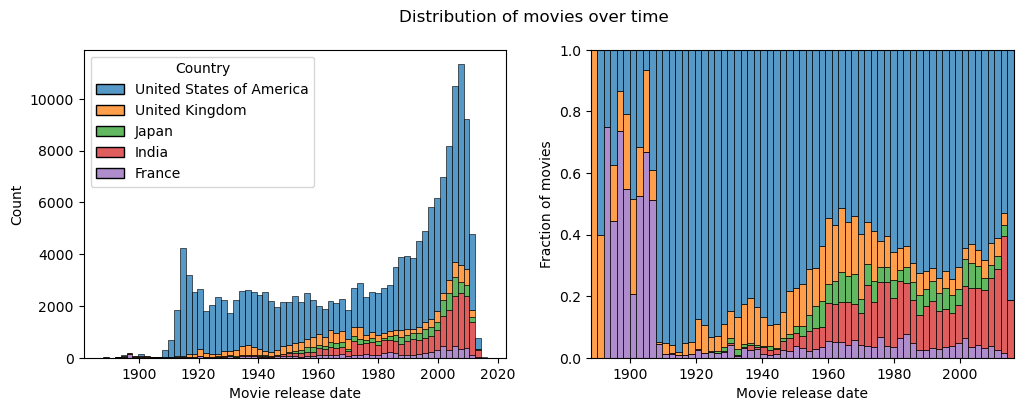

In [13]:
plot.movie_distribution_over_time(movies_parsed)

Based on this visualization we select movies from 1950 to 2010 for our analysis, and see that movies from each country are sufficiently represented.

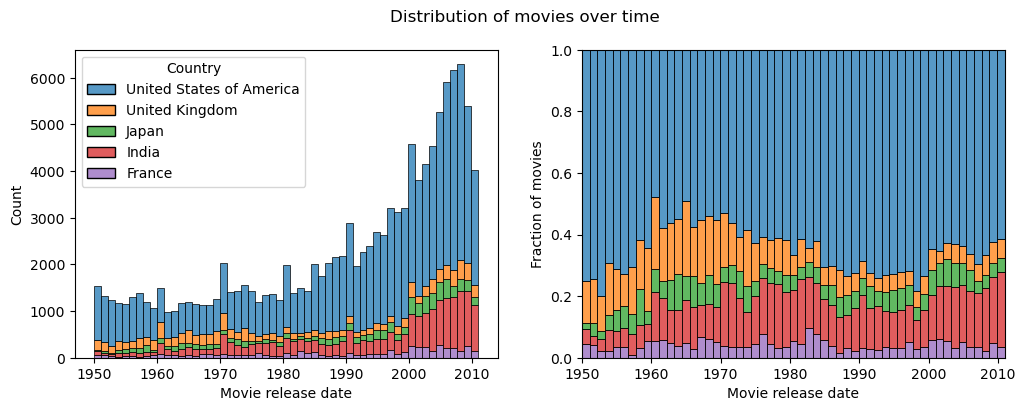

In [14]:
movies = clean.keep_dates(movies_parsed, 1950, 2010)
characters = clean.keep_dates(characters_parsed, 1950, 2010)
plot.movie_distribution_over_time(movies)

This leaves us with 40% of the original movies and 55% of the original characters.

In [15]:
ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
ncharacters = aggregate.ncharacters(characters)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of characters: {ncharacters} ({ncharacters / ncharacters_raw:.1%})')
print(f'- Number of actors:     {nactors} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     32447 (39.7%)
- Number of characters: 102199 (55.7%)
- Number of actors:     70647 (52.0%)


## 3. Analysis of different movie industries

General note: I think one thing we have to be careful of is that results will vary over time (as movie industries have changed over time).
Therefore, it might be smart to split movies into periods and compare the evolution for each country.
Did the movie industries diverge or converge?

### 3.1 Trends in movie industries

Metrics to analyse:
- Movie length
- Movie revenue
- Movie budgets (adjusted for inflation, will need external database for this)
- Movie genres

It could be interesting to have some NLP insights here from the summaries across countries over time

### 3.2 Diversity across industries

Possible metrics between countries:
- Age
- Gender ratio
- Ethnicity (although not much data, not sure if we can complete w/ other datasources)
- Actor height compared to national averages

This task should be similar to H1, just comparing populations using the appropriate statistic metrics.

Initial needed data wrangling:
- Age should be in the right range
- Gender ratio in an appropriate format for comparing
- Check if there is enough ethnicity data and if not try to obtain them from outside data source
- Obtain national heigh averages and compare them with appropriate methods

### 3.3 Success across industries

Our intial question, but now more precisely comparing across different countries.
What factors predict the success of a movie (financial and rating), and do they differ across the different countries?